In this homework, you can pick one of the two sections (Automated Fact-checking or Relatio) to get the full completion point.

# Automated Fact-checking
In the notebook, we see one off-the-shelf fact-check model based on RoBERTa.
However, that setting is more like textual entailment. Real-world Fact-checking pipeline requires an extra module: evidence retrieval. In this homework, we will add an evidence retrieval model based on <b>sentence-bert</b> to the RoBERTa Fact-checker.

Note: SBERT was introduced in Notebook 6 (06_transformers.ipynb).

In [1]:
!wget https://scifact.s3-us-west-2.amazonaws.com/release/latest/data.tar.gz
!tar -xzf data.tar.gz

--2023-05-25 16:50:22--  https://scifact.s3-us-west-2.amazonaws.com/release/latest/data.tar.gz
Resolving scifact.s3-us-west-2.amazonaws.com (scifact.s3-us-west-2.amazonaws.com)... 52.92.176.202, 3.5.77.129, 52.218.168.81, ...
Connecting to scifact.s3-us-west-2.amazonaws.com (scifact.s3-us-west-2.amazonaws.com)|52.92.176.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3115079 (3.0M) [application/x-tar]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   2.97M  2.50MB/s    in 1.2s    

2023-05-25 16:50:24 (2.50 MB/s) - ‘data.tar.gz’ saved [3115079/3115079]



In [2]:
import json

claim_file = 'data/claims_dev.jsonl'
corpus_file = 'data/corpus.jsonl'

corpus = {}
with open(corpus_file) as f:
    for line in f:
        abstract = json.loads(line)
        corpus[str(abstract["doc_id"])] = abstract
        
claims = []
with open(claim_file) as f:
    for line in f:
        claim = json.loads(line)
        claims.append(claim)

print(claims[1])
print(corpus['14717500'])

print("Number of Corpus: ", len(corpus))

{'id': 3, 'claim': '1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.', 'evidence': {'14717500': [{'sentences': [2, 5], 'label': 'SUPPORT'}, {'sentences': [7], 'label': 'SUPPORT'}]}, 'cited_doc_ids': [14717500]}
{'doc_id': 14717500, 'title': 'Rare Variants Create Synthetic Genome-Wide Associations', 'abstract': ['Genome-wide association studies (GWAS) have now identified at least 2,000 common variants that appear associated with common diseases or related traits (http://www.genome.gov/gwastudies), hundreds of which have been convincingly replicated.', 'It is generally thought that the associated markers reflect the effect of a nearby common (minor allele frequency >0.05) causal site, which is associated with the marker, leading to extensive resequencing efforts to find causal sites.', 'We propose as an alternative explanation that variants much less common than the associated one may crea

In [3]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm


def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# utility function for cosine similarity calculation
def cosine_similarity_matrix(vector, matrix):
    return np.apply_along_axis(cosine_similarity, 1, matrix, vector)

# preprocessing function for SciFact corpus
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    return text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=d86335b944f2449b0ea819839465c43015f0866c16d2d6115b413fe197c56729
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


### TODO 1: find the top-10 evidences for the following claim USING SBERT.

In [4]:
claim_1 = claims[1]['claim']

corpus_ids, corpus_texts = [], []
for k, v in corpus.items():
  original_sentences = [v['title']] + v['abstract']
  processed_paragraph = " ".join([preprocess_sentence(sentence) for sentence in original_sentences])
  corpus_ids.append(k)
  corpus_texts.append(processed_paragraph)

# TODO: find the top-10 evidences for claim_1 using SBERT
# Hint 1: use Colab's GPU (or your local GPUs) to accelerate SBERT Encoding
# Hint 2: use parallel encoding (i.e. batch encoding) from SBERT to accelerate encoding.
# Hint 3: SciFact is a scientific domain dataset. Are there SBERT models on the same domain?

model = "bert-base-nli-mean-tokens"
embedder = SentenceTransformer(model)

c1_embedded = embedder.encode(claim_1)

batch_size = 128
corpus_emb = []


for i in tqdm(range(0, len(corpus_texts), batch_size)):
  batch = corpus_texts[i:i+batch_size]
  emb = embedder.encode(batch)
  corpus_emb.extend(emb)


similarity = cosine_similarity_matrix(c1_embedded, np.array(corpus_emb))

top_index = np.argsort(similarity, axis=0)[::-1][:10]
top_evidences = [(corpus_ids[i], corpus_texts[i]) for i in top_index]

for evidence in top_evidences:
    print(evidence)



100%|██████████| 41/41 [00:43<00:00,  1.05s/it]

('1388704', 'the essence of snps .  single nucleotide polymorphisms (snps) are an abundant form of genome variation, distinguished from rare variations by a requirement for the least abundant allele to have a frequency of 1% or more .  a wide range of genetics disciplines stand to benefit greatly from the study and use of snps .  the recent surge of interest in snps stems from, and continues to depend upon, the merging and coincident maturation of several research areas, i . e .  (i) large-scale genome analysis and related technologies, (ii) bio-informatics and computing, (iii) genetic analysis of simple and complex disease states, and (iv) global human population genetics .  these fields will now be propelled forward, often into uncharted territories, by ongoing discovery efforts that promise to yield hundreds of thousands of human snps in the next few years .  major questions are now being asked, experimentally, theoretically and ethically, about the most effective ways to unlock the

### TODO 2: use Dzeniks/roberta-fact-check and the retrieved evidence to verify the claim. You can use one or multiple evidence.

In [5]:
#!pip install transformers
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [6]:
# TODO: use Dzeniks/roberta-fact-check and the retrieved evidence to verify the claim. You can use one or multiple evidence.

model_name = "Dzeniks/roberta-fact-check"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)


In [7]:
evidence_text = top_evidences[0][1]
print(evidence_text[:70], '...')

encoded_input = tokenizer.encode_plus(
    claim_1,
    evidence_text,
    add_special_tokens=True,
    truncation=True,
    padding="longest",
    return_tensors="pt"
)

input_ids = encoded_input["input_ids"]
attention_mask = encoded_input["attention_mask"]

outputs = model(input_ids=input_ids, attention_mask=attention_mask)
logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1).flatten().tolist()

prediction = predicted_labels[0]
print("Claim prediction:", bool(prediction))


the essence of snps .  single nucleotide polymorphisms (snps) are an a ...
Claim prediction: True


# Relatio

In [8]:
!pip install relatio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.5/464.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 43.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 776.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
# Catch warnings for an easy ride
from relatio import FileLogger
logger = FileLogger(level = 'WARNING')

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


In [11]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["doc"] = df["title"] + " " + df["lead"]
df["id"] = df.index
df = df[['id', 'doc']]
df.head()

df = df.sample(n=5000)

--2023-05-25 16:59:09--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M  --.-KB/s    in 0.07s   

2023-05-25 16:59:11 (385 MB/s) - ‘train.csv’ saved [29470338/29470338]



### TODO 1: Predict the Semantic Roles in the AG news dataset. 

In [12]:
df.head()

,id,doc
13430,13430,"No Lie, the Moment of Truth Grows Near We're d..."
7605,7605,Power failure hits Bahrain A total power black...
111275,111275,Nintendo boss slams PSP as DS shipment target ...
75008,75008,Federal Reserve #39;s Eighth District economy ...
118376,118376,Science Magazine Names Mars Discovery Breakthr...


In [13]:
from relatio import Preprocessor, SRL, extract_roles

# TODO 1: Predict the Semantic Role Labels in the AG news dataset.
# Hint: you can sample a few sentences to accelerate SRL prediction.

preprocessor = Preprocessor(
    spacy_model = "en_core_web_sm",
    remove_punctuation = True,
    remove_digits = True,
    lowercase = True,
    lemmatize = True,
    remove_chars = ["\"",'-',"^",".","?","!",";","(",")",",",":","\'","+","&","|","/","{","}",
                    "~","_","`","[","]",">","<","=","*","%","$","@","#","’"],
    stop_words = [],
    n_process = -1,
    batch_size = 100
)

srl = SRL(
    path = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz",
    batch_size = 10,
    cuda_device = -1
)

df = preprocessor.split_into_sentences(
    df, output_path = None, progress_bar = True
)

  warnings.warn(warn_msg)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Output()

Splitting into sentences...


100%|██████████| 5000/5000 [00:23<00:00, 215.23it/s]


In [14]:
srl_pred = srl(df['sentence'], progress_bar=True)

roles, _ = extract_roles(
    srl_pred,
    used_roles = ["ARG0","B-V","B-ARGM-NEG","B-ARGM-MOD","ARG1","ARG2"],
    only_triplets = True,
    progress_bar = True
)

for d in roles[0:20]: print(d)

Running SRL...


100%|██████████| 649/649 [30:46<00:00,  2.84s/it]


Extracting semantic roles...


100%|██████████| 6486/6486 [00:01<00:00, 4738.40it/s]

{'ARG0': 'blackout', 'B-V': 'hit', 'ARG1': 'Power failure hits Bahrain A total power Bahrain'}
{'ARG0': 'Nintendo boss', 'B-V': 'slams', 'ARG1': 'PSP'}
{'ARG0': 'PlayStation Portable handheld', 'B-V': 'attract', 'ARG1': 'newcomers to gaming'}
{'ARG0': 'some manufacturers in the Federal Reserve # 39;s Eighth District', 'B-V': 'planned', 'ARG1': 'to expand and add jobs in the last few months , about the same number planned to close plants and cut jobs'}
{'ARG0': 'some manufacturers in the Federal Reserve # 39;s Eighth District', 'B-V': 'expand', 'ARG1': 'jobs'}
{'ARG0': 'some manufacturers in the Federal Reserve # 39;s Eighth District', 'B-V': 'add', 'ARG1': 'jobs about the same number planned to close plants and cut jobs'}
{'ARG0': 'the same number', 'B-V': 'cut', 'ARG1': 'jobs'}
{'ARG0': 'Science Magazine Names Mars', 'B-V': 'leaving', 'ARG1': 'Endurance Crater , Opportunity rovers panoramic camera , or Pancam'}
{'ARG0': 'Science Magazine Names Mars Discovery Breakthrough of the Year B

### TODO 2: Postprocess the retrieved semantic roles

In [23]:
# TODO 2: Postprocess the retrieved semantic roles
# Hint: use p.process_roles

processed_roles = preprocessor.process_roles(
    roles,
    max_length = 50,
    progress_bar = True,
    )

for d in processed_roles[0:20]: print(d)


Cleaning phrases for role ARG0...


100%|██████████| 12888/12888 [00:37<00:00, 339.76it/s]


Cleaning phrases for role B-V...


100%|██████████| 12888/12888 [00:28<00:00, 448.81it/s]


Cleaning phrases for role B-ARGM-MOD...


100%|██████████| 1006/1006 [00:01<00:00, 603.35it/s]


Cleaning phrases for role ARG1...


100%|██████████| 12466/12466 [00:39<00:00, 315.83it/s]


Cleaning phrases for role ARG2...


100%|██████████| 1924/1924 [00:04<00:00, 422.97it/s]


{'ARG0': 'blackout', 'B-V': 'hit', 'ARG1': 'power failure hit bahrain a total power bahrain'}
{'ARG0': 'nintendo boss', 'B-V': 'slams', 'ARG1': 'psp'}
{'ARG0': 'playstation portable handheld', 'B-V': 'attract', 'ARG1': 'newcomer to game'}
{'B-V': 'plan'}
{'B-V': 'expand', 'ARG1': 'job'}
{'B-V': 'add'}
{'ARG0': 'the same number', 'B-V': 'cut', 'ARG1': 'job'}
{'ARG0': 'science magazine names mars', 'B-V': 'leave'}
{'B-V': 'capture', 'ARG1': 'this view of quot burn cliff quot'}
{'B-V': 'quot burn', 'ARG1': 'cliff quot'}
{'ARG0': 'united airlines', 'B-V': 'say'}
{'ARG0': 'it', 'B-V': 'need'}
{'ARG0': 'it', 'B-V': 'cut'}
{'ARG0': 'chicago united airlines official', 'B-V': 'say'}
{'ARG0': 'they', 'B-V': 'need'}
{'ARG0': 'they', 'B-V': 'cut'}
{'ARG0': 'british scientist', 'B-V': 'work', 'ARG1': 'on drug to fight malaria at least people'}
{'ARG0': 'drug', 'B-V': 'fight', 'ARG1': 'malaria'}
{'ARG0': 'afp afp rio ferdinand', 'B-V': 'plan'}
{'ARG0': 'he', 'B-V': 'return', 'ARG1': 'for miss a drug

### TODO 3: Extract the named entities that can be recognized from the semantic roles.

In [22]:
# TODO 3: Extract the named entities that can be recognized from the semantic roles.
# Hint use p.mine_entities

known_entities = preprocessor.mine_entities(
    df['sentence'], 
    clean_entities = True, 
    progress_bar = True,
)

for n in known_entities.most_common(10): print(n)


Mining named entities...


100%|██████████| 6486/6486 [00:42<00:00, 153.64it/s]

('reuters', 623)
('ap', 601)
('us', 402)
('u s', 264)
('iraq', 211)
('new york', 160)
('microsoft', 154)
('china', 121)
('bush', 111)
('the united states', 106)


### TODO 4: modeling the narratives

In [24]:
from relatio.narrative_models import NarrativeModel

# TODO 4: modeling the narratives using NarrativeModel
# Hint: follow the notebook's hyperparameter setting

top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

narrative_model = NarrativeModel(
    clustering = 'kmeans',
    PCA = True,
    UMAP = True,
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1'],
    roles_with_known_entities = ['ARG0','ARG1'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'embeddings',
    roles_with_unknown_entities = ['ARG0','ARG1'],
    threshold = 0.1
)    
             
narrative_model.fit(processed_roles, progress_bar = True) 
 

Computing phrase embeddings...


100%|██████████| 6650/6650 [01:05<00:00, 100.77it/s]


Computing phrase embeddings...


100%|██████████| 7317/7317 [01:15<00:00, 96.29it/s] 


Computing phrase embeddings...


100%|██████████| 13444/13444 [02:19<00:00, 96.35it/s] 


Dimension reduction via PCA...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
Dimension reduction via UMAP...
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}


  warnings.warn(



Clustering phrases into clusters...
Clustering parameters chosen in this range:
{'n_clusters': [13, 33, 66, 99, 134], 'random_state': 0}


  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



The silhouette score suggests the optimal number of clusters is 134. This corresponds to index 4.
The elbow method (inertia score) suggests the optimal number of clusters is 33. This corresponds to index 1.
Labeling the clusters by the most frequent phrases...


  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



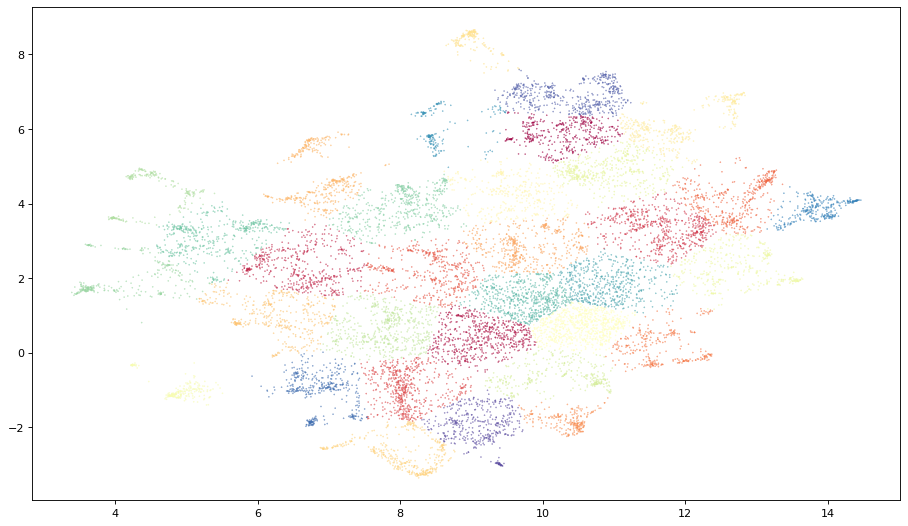

In [25]:
narrative_model.plot_clusters(path = './clusters.pdf')